In [1]:
import pandas as pd
import numpy as np
import json
import requests
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import re
import logging
import concurrent.futures
from tqdm import tqdm
import time
import ftfy

# Setup logging to both console and file
logging.basicConfig(level=logging.INFO, format='%(asctime)s:%(levelname)s:%(message)s', handlers=[
    logging.FileHandler("essay_scoring.log"),
    logging.StreamHandler()
])

# Load the dataset
data_path = 'cleandata_t2_no_examples_final.csv'
dataframe = pd.read_csv(data_path)

# Randomly select 700 rows from the dataset for testing
subset = dataframe.sample(n=400, random_state=42)

# Define example essays with scores
example_essays = [
    {
        "score": 9,
        "essay": "Some people today believe that it is acceptable to use physical force to discipline children, but others feel it is completely unacceptable.Discuss this view and give your opinion.Give reasons for your answer and include any relevant examples from your knowledge or experience. You should write at least 250 words. Punishing children with physical force, or corporal punishment as it is also called, is something that was accepted not so long ago and people over the age of forty may well remember it. Nowadays, however, corporal punishment is against the law in most countries and adults who practise it can be taken to court. Children are always a vulnerable group and they depend on adults for protection and education. Of course, part of the growing up process is testing and breaking boundaries and it is nearly always necessary to instill discipline on a child. Whether or not it is necessary to use physical force to do so can be a very emotive subject.Supporters of corporal punishment often defend their standpoint by explaining that the corporal punishment is not, or should not be, excessive. They do not argue that a child should be beaten severely until he or she is bruised or cut. They argue that just the infliction of mild pain causes effective discipline and also the fear that it might be applied. People who grew up experiencing it might offer this point of view.Those who oppose using physical force on a child would say that the vulnerability and innocence of a child means that force should never be used. Children need to trust adults and believe that no harm will come to them. Additionally, children learn from adults and it is argued that corporal punishment will only teach children that force is an answer to various problems. It is also claimed that corporal punishment has no added benefits over other forms of discipline that do not require physical force. Using it can cause psychological harm to children and should be classed as child abuse.Personally, I do not believe that limited use of forms of corporal punishment can cause harm, and a parent who administers a mild form of it to his or her child should not be subject to criminal proceedings. Nevertheless, I would not use it myself. I can also recognise the possibilities of adults who are not a child‚Äôs parents misusing corporal punishment. Therefore, I believe that on balance physical force to discipline children should not be permitted."},
    {
        "score": 8,
        "essay": "Write about the following topic.An increasing number of people are choosing to have cosmetic surgery in order to improve their appearance. Why are more people choosing to have operation to change the way they look? Do you think this a positive or negative development?Give reasons for your answer and include any relevant examples from your own knowledge or experience. There is currently a contentious argument regarding the purpose of having cosmetic surgery since more and more people prefer to use this method to improve their appearance. Considering the factors that support the decision to choose this improvement method, there are various reasons which I will discuss in this essay. In terms of consequences, I personally believe that there is a positive development. It is the fact that people have a wide variety of rationales to have cosmetic surgery. An obvious example of this is that people can design their new appearance in the way they wish to be look like. This is because a doctor could perform modern medical techniques such as modifying bone at the patients‚Äô nose to change their real face, which natural face improvement cannot do. Another common reason is the increase in self-confidence. When people have plastic surgery, they tend to believe that their appearance will be more accepted by other people, helping them to feel more confident. Contemplating the effects of people who have plastic surgery, there are many vital advantages. A common criticism in favour of this is the rise in productivity in workplace. When people feel more confident as a result of having cosmetic surgery, they tend to be more courageous to communicate with people in other departments, leading to the increasing workflow between two teams. Another classic example is building more networking. This is because people who positively improve their appearance tend to attract other people‚Äôs attention. As a result, more and more people might want to know them. In conclusion, it is undeniable that cosmetic surgery could address people‚Äôs eagerness to have better appearance and be more confident, which, in my opinion, results in a positive consequence to both society and them. This is because they would have willingness to contact other people and draw other people‚Äôs attention to them, which could grow their connections."},
    {
        "score": 7,
        "essay": "In many countries people increasingly talk about money (how much they earn or how much they pay for things in their daily conversations). Why? Is this a positive or negative development? Money can not buy happiness! Is one of the most famous sayings while talking about finances. It is argued that topics around money, wealth, and poverty are becoming dramatically more frequent between humans in different countries around the world. In my opinion, the extream part of it is a negative development; although, it has some positivities. I will address some of both sides in this essay. Talking about money during the major part of the day might make the person look stingy and this is an attitude that majority of the community would not like, thus, might effect on the person's social life. Moreover, having the same topic in mind all day might lead to an obsession, and as a result, this could lead to a depression because the person might not find the proper way to reach to the financial position that meets their satisfaction, which could lead to depression, or even worse such as going through illegal paths where it could destroy their lives entirely! Nevertheless, the person should be aware of his /her income and spendings and try to enhance their financial position to the best possible way. Also, the inflation that we are currently living and the noticable increase in prices could be a driver for people to talk about money more often. In conclusion, people should not be obssessed in money and to talk with everyone about it all the time. However, I believe that people should discuss this matter in order to benefit from each other, and to find more ways to enhance their quality of life."},
    {
        "score": 6,
        "essay": "Write about the following topic.The most important function of music is that it helps people reduce stress. To what extent do you agree or disagree?Give reasons for your answer and include any relevant examples from your own knowledge or experience. Listening to music is a very relaxing excercise, for some people more that other. In my opinion, reducing people stress is music most important function. Weather playing music or listening to it, are both relaxing activities. Listening to music is very relaxing and it will help you reduce stress. One can listen to music at home or while doing outdoor activities like running or going to the gym. Listening to music after a long working day is a greate practice that will help you decrease stress. There are diferent types of music, some are belived to be more relaxing than others like classical music compare to rock and roll. Scientists have demostrated by several investigations that music helps people reduce stress, after listening to music people feel more calm and have more clear thoughts. Some people think that music most important function is not reducing stress , instead they found it superficial and distracting. They think other activities are better at reducing stress like yoga or playing sports. Not all people feel relax by listening to music, some may find it unconfortable or unnecessary. To summarise music most important function is that helps people reduce stress. Music as a tool for reducing stress can be used by listening to it at the end of your day or during it, this will help you overcome your weekly rutine. Classical music is recomended over several styles of music to be the more relaxing one. Listening to music can help you take better decisions and overcome dificult situations that could present in your daily rutine."},
    {
        "score": 5,
        "essay": "Some people say free time activities for children should be organized by parents. Others say that children should be free to choose what they do in their free time. Discuss both views and give your opinion. What children like to do in free time ? All children have diffrent ideas and preferences. So that many parenets think what should they provide and organize for their kids or not. Children have free mind. Sometimes that make out of control their behaviours. In this modern world, we have so manyv tools to connect to out side of their world, for example internet, social network. If parents are not organised to kids's freet time, children have so many chance to take those tools. Not all internet stuffs are bad, but also there are lots of appropriate contents for kids around. Kids should be protected and orverviewed by parents or caregivers whatever they are doing. Moreover, if they are not controlled their free time by parents, kids never have limit of spending time for something they are into it. Time management is important for kids, free time shouldn't be until late night. On the other hand, what will be happned if parents don't organised their free time. Kids are using their imagination or ideas in their free time to play. There is no organising stuff from parents, so that they might try to find what they need and want to do. Therefore, they develop their indepndence and social skills. In my opinion, I think kids should be organised their free time by parents. Compared with both side of effect, I personally choose kids's safety rather than developping independence. Independence and social skills can develop in other situation also. Howevere, kids's safety cant choose"},
    {
        "score": 4,
        "essay": "Some people think that physical strength is important for success in sport, while other people think that mental strength is more important. Discuss both views and give your own opinion. Physical strength is the vital role of success in sport while other people think that mentally strong is much more important in the competitive sports. In my opinion, both are correct and to be able to strong people would do more exercises in their long life. On the one hand, people are more willing to suceess in the race of their games and sometimes failed. For the reasons of that they never thought that which would be the answer is that physically strength would give them to succeed in their pace of games and other sports they choice. For example, the more they do exercises before entering the match, the body will strong enough till the end of the contest. Then the succeed will come next of grasp. On the other hand, the mental strength would be the main strength and sources of succeed which is the beginning point of the contest. Not even enough the exercises of mind, people would not get the immense advances of win. It means that people's minds might to be whatever they lose in the math, they can get it and stand up right their pace. As long as they get this point of action into their mind, I believed that they are eagle to strong enough to be ready to their games and other atheletics. Moreover, when they practice before entering the space of match, the embedded mind would be the main sources of mental strength too. It gives them to the progress of steps and the successful way until the end of the sports. To wrap up, people should do more exercies and it will give them mentally and physically strong that I think. By doing both, the successful winner will become next and they will get a success in their tournament and will become a good competitior in the near future."},
    {
        "score": 3,
        "essay": "Write about the following topic.Some people feel that manufacturers and supermarkets have the responsibility to reduce the amount of packaging of goods. Others argue that customers should avoid buying goods with a lot of packaging. Discuss both views and give your opinion.Give reasons for your answer and include any relevant examples from your own knowledge or experience. there is no deying the fact the main requirement of goods it is debatable these days , which some people think the goods it is duty of supermarket , while others believe that responsibility of customers and really we have take a strict way for this issue , in this essay will dicuss both of side and will draw my personal experience , in one hand talking the group of people which but the refer guilty for supermarket and industry , when the products setting in the shop they empleoy of supermarket the must packaing off the goods after that they but them in store , so that why some think tha because it is this esay way when we dealing this proplomitc instaed we aviod , on the other hand it is another story here which the concept it is the custromer halt cunsume buy numres of pack for illustrated the must bring while shopping pack and do not taking from store in , addition even if we forgeat when we geting outdoor try reimend your self prior you go , hence the belife that is very essentail to stop depanding to pursher pack in store , for instance allways kept your bag or with your partner we have a lot of solution to rely our self , prove the clear that it is very harmful for enviorment , my conculsion after we analysis both point veiw , i recommand to ask the street which kind of people you are and after that we solve this issue with count people and make table two sorts of them then we provided him the advice for giving him pack."}
]

# Correct encoding issues in the example essays
for example in example_essays:
    example['essay'] = ftfy.fix_text(example['essay'])

# Rest of your script
def format_example_essays(example_essays):
    formatted_essays = ""
    for example in example_essays:
        formatted_essays += f"Score {example['score']} Essay: {example['essay']} "
    return formatted_essays

formatted_examples = format_example_essays(example_essays)

2024-07-10 12:55:39,435:INFO:Generating score for the prompt (Attempt 1): Prompt: Write about the following topic.Due to the...
2024-07-10 12:55:39,435:INFO:Generating score for the prompt (Attempt 1): Prompt: In many countries people increasingly talk...
2024-07-10 12:55:39,436:INFO:Generating score for the prompt (Attempt 1): Prompt: Write about the following topic.To meet th...
2024-07-10 12:55:39,437:INFO:Generating score for the prompt (Attempt 1): Prompt: Tourism today creates a variety of problem...
2024-07-10 12:55:39,438:INFO:Generating score for the prompt (Attempt 1): Prompt: It is believed that people who read for pl...
2024-07-10 12:55:39,439:INFO:Generating score for the prompt (Attempt 1): Prompt: Boxing is a blood sport which often result...
2024-07-10 12:55:39,439:INFO:Generating score for the prompt (Attempt 1): Prompt: Competitiveness is a positive quality for ...
Grading Essays:   0%|          | 0/400 [00:00<?, ?it/s]2024-07-10 12:55:39,440:INFO:Generating score for

Inputs saved to model_inputs.csv.
Mean Squared Error: 1.5601503759398496
Correlation between actual and predicted ratings: 0.5648218626856063


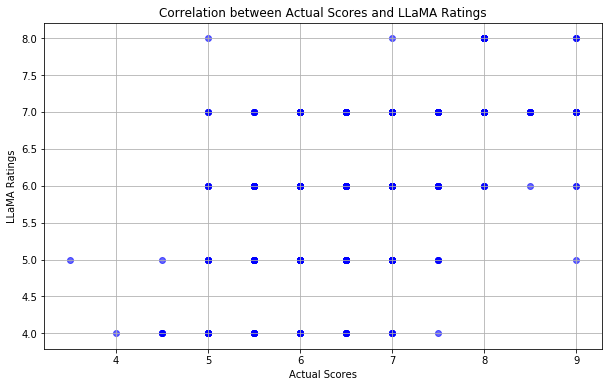

2024-07-10 13:00:39,286:INFO:Output saved with LLaMA ratings.


Output saved with LLaMA ratings.


In [2]:
# Define the system message and prompt template
system_message = (
    "Please act as an IELTS examiner and assess an essay according to the official scoring criteria and example essays."
    "Score 9: Fully developed response, sophisticated vocabulary and structures, no errors. "
    "Score 8: Well-developed, detailed, minor vocabulary and grammar errors. "
    "Score 7: Clear position, relevant ideas, some errors, good control over complex structures. "
    "Score 6: Addresses the task, relevant main ideas, some errors, uses both simple and complex sentences. "
    "Score 5: Addresses the task partially, limited main ideas, frequent errors, limited vocabulary. "
    "Score 4: Minimal response, unclear position, frequent errors, very limited vocabulary and sentence structures. "
    "Score 3: Does not adequately address the task, communication often distorted by errors. "
    "Score 2: Barely responds, no clear position, severe control issues with vocabulary and sentence structures. "
    "Score 1: Unrelated to the task, unable to communicate a clear message. "
    "Score 0: Did not attempt the task. "
    "Expected response format: Score: [0-9] with justification."
    f"Here are some example essays with their scores: {formatted_examples}"
)

API_URL = "https://api-inference.huggingface.co/models/meta-llama/Meta-Llama-3-70B-Instruct"
headers = {
    "Authorization": "",  # Replace with your actual Hugging Face token
    "Content-Type": "application/json",
}

# DataFrame to store the inputs sent to the model
inputs_df = pd.DataFrame(columns=["index", "prompt", "response"])

def query(payload):
    json_body = {
        "inputs": payload,
        "parameters": {"max_new_tokens": 256, "top_p": 0.9, "temperature": 0.7}
    }
    data = json.dumps(json_body)
    while True:
        try:
            response = requests.post(API_URL, headers=headers, data=data)
            response.raise_for_status()  # Raise an error for HTTP error codes
            return json.loads(response.content.decode("utf-8"))
        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 429:  # Too Many Requests
                logging.error("Rate limit exceeded. Waiting for 1 hour before retrying...")
                time.sleep(3700)  # Wait for 1 hour
            else:
                logging.error(f"HTTP error occurred: {e}")
                return None
        except requests.exceptions.RequestException as e:
            logging.error(f"Request failed: {e}")
            return None

# Function to preprocess text by removing line breaks and combining sections
def preprocess_text(question, essay):
    question = question.replace("\n", " ").replace("\r", "")
    essay = essay.replace("\n", " ").replace("\r", "")
    return f"Prompt: {question} Essay: {essay} [/INST]"

# Function to generate scores using the API
def generate_score(prompt, attempt):
    logging.info(f"Generating score for the prompt (Attempt {attempt}): {prompt[:50]}...")
    payload = f"[INST] <<SYS>> {system_message} <<SYS>> {prompt}"
    response = query(payload)
    if response and isinstance(response, list) and 'generated_text' in response[0]:
        output = response[0]['generated_text'].strip()
        logging.info(f"Generated output: {output[:50]}...")
        # Use regex to find the first instance of a numerical score in the output
        match = re.search(r'Score:\s*([0-9])', output)
        if match:
            score = int(match.group(1))
            if 0 <= score <= 9:
                return score, output.replace(f"Score: {score}", "").strip()
            else:
                logging.warning(f"Invalid score {score} found. Retrying...")
                return None, None
        else:
            logging.warning("No score found in output. Retrying...")
            return None, None
    else:
        logging.error("No valid response received. Retrying...")
        return None, None

# Function to process each essay with exponential backoff for retries
def process_essay(index, row, retries=3):
    prompt = preprocess_text(row['Question'], row['Essay'])
    for attempt in range(1, retries + 1):
        score1, justification1 = generate_score(prompt, attempt)
        score2, justification2 = generate_score(prompt, attempt)
        if score1 is not None and score2 is not None:
            if abs(score1 - score2) <= 2:
                mean_score = (score1 + score2) / 2
                return index, mean_score, f"Scores: {score1}, {score2}"
        logging.warning(f"Scores {score1} and {score2} differed by more than 2. Retrying...")
    # If no valid score after retries, return None
    return index, None, None

# Add new columns for LLaMA ratings and justifications
subset['llama_rating'] = np.nan
subset['justification'] = ""

# Use ThreadPoolExecutor for parallel processing
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_essay, index, row) for index, row in subset.iterrows()]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Grading Essays"):
        index, score, justification = future.result()
        if score is not None:
            subset.at[index, 'llama_rating'] = score
            subset.at[index, 'justification'] = justification
        else:
            logging.warning(f"Failed to get a valid score for essay at index {index}. Setting as NaN.")

# Save the inputs to a CSV file
inputs_df.to_csv('model_inputs_with_example.csv', index=False)
print("Inputs saved to model_inputs.csv.")
logging.info("Inputs saved to model_inputs.csv.")

# Check for NaN values and handle them
nan_count = subset['llama_rating'].isna().sum()
if nan_count > 0:
    logging.warning(f"NaN values found in llama_rating: {nan_count} rows.")
    subset.dropna(subset=['llama_rating'], inplace=True)

# Convert columns to float if not already
subset['Overall'] = subset['Overall'].astype(float)
subset['llama_rating'] = subset['llama_rating'].astype(float)

# Calculate and print the mean squared error to evaluate the model
if len(subset) > 0:
    mse = mean_squared_error(subset['Overall'], subset['llama_rating'])
    print(f"Mean Squared Error: {mse}")
    logging.info(f"Mean Squared Error: {mse}")

    # Optional: Calculate and print correlation for additional evaluation
    correlation = np.corrcoef(subset['Overall'], subset['llama_rating'])[0, 1]
    print(f"Correlation between actual and predicted ratings: {correlation}")
    logging.info(f"Correlation between actual and predicted ratings: {correlation}")

    # Plotting the correlation
    plt.figure(figsize=(10, 6))
    plt.scatter(subset['Overall'], subset['llama_rating'], alpha=0.6, color='blue')
    plt.title('Correlation between Actual Scores and LLaMA Ratings')
    plt.xlabel('Actual Scores')
    plt.ylabel('LLaMA Ratings')
    plt.grid(True)
    plt.show()

# Save the subset with LLaMA ratings for further analysis
subset.to_csv('output_with_llama_with_example.csv', index=False)
print("Output saved with LLaMA ratings.")
logging.info("Output saved with LLaMA ratings.")

